# Question 3

### Loading the Libraries and Data

In [1]:
import numpy as np                        #loading the relevant libraries
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from functools import partial              #for creating new functions from existing ones, with fixed parameters

X=[0,6,10,13,17,20,28]  #Days
Y_1=[15.67,20.33,30.67,25.33,35.10,30.31,28.5] #Sample 1 weight
Y_2=[15.67,17.11,20.89,15.00,10.56,10.44,8.5] #Sample 2 weight
n=len(X)-1

### Code for computing the coefficients of the cubic spline

In [2]:
def spline(X: list, Y: list)-> list:   #using the algorithm 3.4 from the book
    Coefflist=[]    #list of coefficients of the cubic spline interpolation polynomial
    n=len(X)-1                         #n is the number of intervals, and hence the number of data points minus 1

    a=Y
    h=[X[i+1]-X[i] for i in range(n)]
    
    alpha=[0]+[3*(a[i+1]-a[i])/h[i]-3*(a[i]-a[i-1])/h[i-1] for i in range(1,n)]
    
    l=[1]
    mu=[0]
    z=[0]

    for i in range(1,n):
        l+=[2*(X[i+1]-X[i-1])-h[i-1]*mu[i-1]]
        mu+=[h[i]/l[i]]
        z+=[(alpha[i]-h[i-1]*z[i-1])/l[i]]
        
    l+=[1]
    z+=[0]
    c=[0]*(n+1)
    b=[0]*n
    d=[0]*n

    for j in range(n-1,-1,-1):
        c[j]=z[j]-mu[j]*c[j+1]
        b[j]=(a[j+1]-a[j])/h[j]-h[j]*(c[j+1]+2*c[j])/3
        d[j]=(c[j+1]-c[j])/(3*h[j])

    Coefflist=[a[:n],b,c,d]

    return Coefflist


### Formatting the output coefficients

In [3]:
fullspline_1=spline(X,Y_1)   #the coefficients of the cubic spline interpolation for the first set of data points
fullspline_2=spline(X,Y_2)   #the coefficients of the cubic spline interpolation for the second set of data points


In [4]:
def splinecoef_to_poly(coeff):    #converts the coefficients of the cubic spline interpolation to the polynomial form
                                  #in each subinterval,
                                  #for evaluation of the cubic spline interpolation at any point
    n=len(coeff[0])
    polylist=[]
    for i in range(n):
        polylist+=[[coeff[0][i],coeff[1][i],coeff[2][i],coeff[3][i]]]
    return polylist

import pandas as pd  #import pandas for creating a formatted table of the coefficients of the cubic spline interpolation

full_data=[]

for i in range(len(fullspline_1[0])):      #to obtain the full coefficient set for the cubic spline interpolation

    full_data+=[splinecoef_to_poly(fullspline_1)[i]+splinecoef_to_poly(fullspline_2)[i]]


full_data=np.array(full_data)

header=pd.MultiIndex.from_product([['Weight 1','Weight 2'],['a','b','c','d']])

df=pd.DataFrame(full_data,columns=header,index=X[:-1])
df.index.name='x'
df=df.round(2).astype(str)
df.to_latex('Spline_DATA.tex')      #to export the data to a latex file

print(df)




   Weight 1                      Weight 2                     
          a      b      c      d        a      b      c      d
x                                                             
0     15.67  -0.34    0.0   0.03    15.67  -0.28    0.0   0.01
6     20.33   3.01   0.56  -0.17    17.11   1.27   0.26  -0.08
10    30.67  -0.51  -1.44   0.34    20.89  -0.74  -0.76   0.12
13    25.33   0.01   1.62  -0.25     15.0  -2.12    0.3  -0.01
17     35.1   0.84  -1.41    0.2    10.56   -0.3   0.15  -0.02
20    30.31  -2.25   0.38  -0.02    10.44   0.02  -0.05    0.0


### Code for evaluating the spline at a given point

In [5]:
data_1=splinecoef_to_poly(fullspline_1)   #store the splines in polynomial format in variable data_1 and data_2
data_2=splinecoef_to_poly(fullspline_2)


def spline_eval(data: list, x: float)-> float:    #evaluates the cubic spline interpolation at any point x
                                                  #it takes data_1 or data_2 as the first argument 
                                                  # and the point x as the second argument
    n=len(data)
    for i in range(n):
        if x>=X[i] and x<=X[i+1]:
            return data[i][0]+data[i][1]*(x-X[i])+data[i][2]*(x-X[i])**2+data[i][3]*(x-X[i])**3
    else:
        return data[-1][0]+data[-1][1]*(x-X[-1])+data[-1][2]*(x-X[-1])**2+data[-1][3]*(x-X[-1])**3

def spline_plot(data: list, X: list, Y: list)-> None:  #plots the cubic spline interpolation 
                                                       #with half a day (12hrs) intervals
    n=len(data)
    x=np.arange(X[0],X[n]+0.5,0.5)  #adding 0.5 to X[n] to include the last point
    y=[spline_eval(data,i) for i in x]
    plt.plot(x,y)
    plt.plot(X,Y,'o')


f1=partial(spline_eval,data_1)     #f1 evaluates the cubic spline interpolation for the first set of data points at any point
f2=partial(spline_eval,data_2)     #f2 evaluates the cubic spline interpolation for the second set of data points at any point

### Comparing Lagrange and Cubic Spline

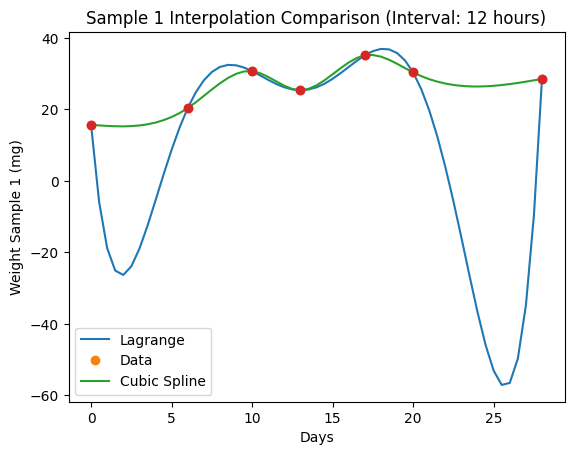

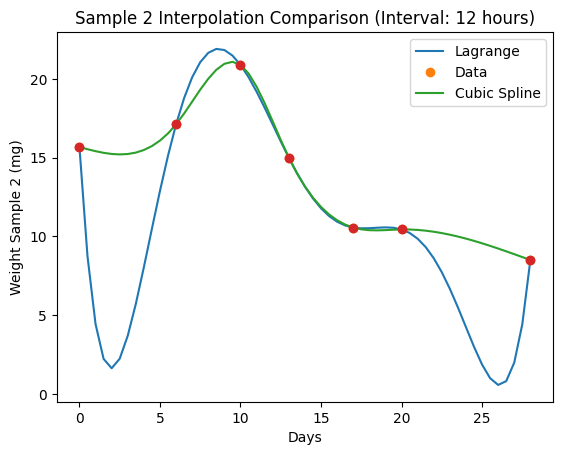

In [6]:
def lagrange(A,B):    #Langrange interpolation
    n=len(A)
    def L(i,x):
        l=1
        for j in range(n):
            if j!=i:
                l*=(x-A[j])/(A[i]-A[j])
        return l
    def P(x):       #P is the Lagrange interpolation polynomial, x is the point at which the polynomial is evaluated
        p=0
        for i in range(n):
            p+=B[i]*L(i,x)
        return p
    return P

def lagrange_plot(A,B):    #plots the Lagrange interpolation
    P=lagrange(A,B)
    x=np.arange(A[0],A[-1]+0.5,0.5)  #with half a day (12hrs) intervals
                                     #A[-1]+0.5 is the right endpoint, 
                                     #since the range function does not include the right endpoint

    y=[P(i) for i in x]
    plt.plot(x,y)
    plt.plot(A,B,'o')
    
lagrange_plot(X,Y_1)
spline_plot(data_1,X,Y_1)
plt.legend(['Lagrange','Data','Cubic Spline'])
plt.xlabel('Days')
plt.ylabel('Weight Sample 1 (mg)')
plt.title('Sample 1 Interpolation Comparison (Interval: 12 hours)')
plt.show()

lagrange_plot(X,Y_2)
spline_plot(data_2,X,Y_2)
plt.legend(['Lagrange','Data','Cubic Spline'])
plt.xlabel('Days')
plt.ylabel('Weight Sample 2 (mg)')
plt.title('Sample 2 Interpolation Comparison (Interval: 12 hours)')
plt.show()



### Finding out the global maximum for each spline

In [7]:
def derivative_spline(data,x,step):  #forward divided difference approximation for the derivative of the cubic spline interpolation
    return (spline_eval(data,x+step)-spline_eval(data,x))/step


def double_derivative_spline(data,x,step):  #forward divided difference approximation 
                                            #for the second derivative of the cubic spline interpolation
                                            #using the first derivative function
    return (derivative_spline(data,x+step,step)-derivative_spline(data,x,step))/step

In [10]:
#evaluate derivative at all the data points

X_with_midpoints=[]    #to obtain the derivative at the midpoints of the intervals

for i in range(len(X)-1):
    X_with_midpoints+=[X[i],(X[i]+X[i+1])/2]
X_with_midpoints+=[X[-1]]

T=X_with_midpoints    #T is the list of points at which the derivative is evaluated
 
derivative_data_1=[derivative_spline(data_1,i,10**(-4)) for i in T]
derivative_data_2=[derivative_spline(data_2,i,10**(-4)) for i in T]

root_containing_intervals_1=[]   #to store the intervals that contain the roots of the derivative for the first sample
root_containing_intervals_2=[]   #to store the intervals that contain the roots of the derivative for the second sample

for i in range(len(derivative_data_1)-1):
    if derivative_data_1[i]*derivative_data_1[i+1]<0:  #if the derivative changes sign in the interval
        root_containing_intervals_1+=[(T[i],T[i+1])]   #then the interval contains a root
    if derivative_data_2[i]*derivative_data_2[i+1]<0:
        root_containing_intervals_2+=[(T[i],T[i+1])]

print('Root Containing Intervals for first sample: ',root_containing_intervals_1)
print('Root Containing Intervals for second sample: ',root_containing_intervals_2)


def bisection(f,a,b,tol):  #bisection method for finding the roots of the derivative
    if f(a)*f(b)>0:
        print('No root in this interval')
        return None
    else:
        while abs(b-a)>tol:
            c=(a+b)/2
            if f(c)==0:
                return c
            elif f(a)*f(c)<0:
                b=c
            else:
                a=c
        return (a+b)/2


Df1=partial(derivative_spline,data_1,step=10**(-4))    #Df1 is the derivative of the cubic spline interpolation for the first sample
Df2=partial(derivative_spline,data_2,step=10**(-4))    #Df2 is the derivative of the cubic spline interpolation for the second sample

DDf1=partial(double_derivative_spline,data_1,step=10**(-4))  #DDf1 is the second derivative of the cubic spline interpolation for the first sample
DDf2=partial(double_derivative_spline,data_2,step=10**(-4))  #DDf2 is the second derivative of the cubic spline interpolation for the second sample



roots_1=[bisection(Df1,i[0],i[1],10**(-4)) for i in root_containing_intervals_1] #roots_1 is the list of roots of the derivative for the first sample
roots_2=[bisection(Df2,i[0],i[1],10**(-4)) for i in root_containing_intervals_2] #roots_2 is the list of roots of the derivative for the second sample

print('Extreme values at: ',roots_1,'for first sample')
print('Extreme values at: ',roots_2,'for second sample')
#check the sign of the double derivative at the roots

maxima_list_1=[]
maxima_list_2=[]

for i in roots_1:
    if DDf1(i)<0:  #if the second derivative is negative at the root, then it is a maximum
        maxima_list_1+=[i]
for i in roots_2:
    if DDf2(i)<0:
        maxima_list_2+=[i]

print('Maxima for first sample at: ',maxima_list_1)
print('Maxima for second sample at: ',maxima_list_2)


#Find the global maximum

global_maxima_1=0
global_maxima_2=0

for i in maxima_list_1:
    if len(maxima_list_1)==0:
        global_maxima_1="No extrema found." 
    if f1(i)>f1(global_maxima_1):  #search for the global maximum
        global_maxima_1=i

for i in maxima_list_2:
    if len(maxima_list_2)==0:
        global_maxima_2="No extrema found."
    if f2(i)>f2(global_maxima_2):
        global_maxima_2=i


print('\n')
print('Global Maximum for first sample at: ',round(global_maxima_1,2),"with value: ",round(f1(global_maxima_1),2))
print('Global Maximum for second sample at: ',round(global_maxima_2,2),"with value: ",round(f2(global_maxima_2),2))


Root Containing Intervals for first sample:  [(0, 3.0), (8.0, 10), (11.5, 13), (17, 18.5), (20, 24.0)]
Root Containing Intervals for second sample:  [(0, 3.0), (8.0, 10), (17, 18.5), (20, 24.0), (24.0, 28)]
Extreme values at:  [1.9162445068359375, 9.816131591796875, 12.996658325195312, 17.320297241210938, 23.930938720703125] for first sample
Extreme values at:  [2.5338592529296875, 9.464874267578125, 18.405838012695312, 20.169464111328125, 27.999908447265625] for second sample
Maxima for first sample at:  [9.816131591796875, 17.320297241210938]
Maxima for second sample at:  [9.464874267578125, 20.169464111328125, 27.999908447265625]


Global Maximum for first sample at:  17.32 with value:  35.23
Global Maximum for second sample at:  9.46 with value:  21.08
